In [1]:
#Football pitch package instalation for Colab enviroment
!pip install mplsoccer -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 1.9 MB/s eta 0:00:00


In [2]:
#Import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

#Football packages
from mplsoccer import Pitch, VerticalPitch, FontManager

#statistics package
import statsmodels.api as sm
import statsmodels.formula.api as smf

#import font type OpenSans
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('/content/drive/MyDrive/OpenSans-Italic-VariableFont_wdth,wght[1].ttf')
plt.rcParams["font.family"] = "Open Sans"
warnings.filterwarnings("ignore")

In [3]:
###Data upload and transform to parquet file from StatsBomb open source github account###

#Loading parquet file with each World Cup data
wc_women_2019 = pd.read_parquet('/content/drive/MyDrive/Football/WorldCup/world_cup_women_all_shots_2019') #shots events World Cup 2019
wc_women_2023 = pd.read_parquet('/content/drive/MyDrive/Football/WorldCup/world_cup_women_all_shots_2023') #shots events World Cup 2023

#Loading parquet file with each WSL seasons data
season_2018 =pd.read_parquet('/content/drive/MyDrive/Football/WomenSuperLeague/wsl_all_shots_2018_2019') #shots events WSL season 2018/2019
season_2019 =pd.read_parquet('/content/drive/MyDrive/Football/WomenSuperLeague/wsl_all_shots_2019_2020') #shots events WSL season 2019/2020
season_2021 = pd.read_parquet('/content/drive/MyDrive/Football/WomenSuperLeague/wsl_all_shots_2022_2021') #shots events WSL season 2020/2021

In [13]:
def data_model_extraction(season):
  """Extracting and transform data from Statsbomb df format
  Keyword arguments:
  season -- dataframe
  """
  #fillter only for open play events from data
  season = season.query('shot_type == "Open Play"')
  season[['x', 'y']] = season.location.to_list()
  #apply StatsBomb pitch dimension data (120 - length, 80 - width)
  season['x'] = season['x'].apply(lambda cell: 120 - cell)
  season['y'] = season['y'].apply(lambda cell: cell)
  #distance from half of pitch (80/2)
  season['c'] = season['y'].apply(lambda cell: abs(cell-40))
  #distance calcualtion
  season["distance"] = np.sqrt(season['x']**2 + season['c']**2)
  # formula for angle calculation
  season['angle'] = np.where(np.arctan(7.32 * season['x'] / (season['x']**2 + season['c']**2 - (7.32/2)**2)) > 0, np.arctan(7.32 * season['x'] /
   (season['x']**2 + season['c']**2 - (7.32/2)**2)), np.arctan(7.32 * season['x'] /(season['x']**2 + season["c"]**2 - (7.32/2)**2)) + np.pi)
  #assign new column to df with number 1 value equal shots was a goal
  season['Goal'] = season.shot_outcome.apply(lambda x: 1 if 'Goal' in x else 0).astype(object)
  season[['X', 'Y']] = season.location.to_list()
  #return data frame
  return season

In [14]:
#root code from Soccermatics course: https://soccermatics.readthedocs.io/en/latest/
#xG model code
def xG_model(input_frame):
  """Apply xG model to calculate variables from df
  Keyword arguments:
  input_frame -- dataframe
  """
  #creating one extra variables
  input_frame['ax']  = input_frame['angle']*input_frame['x']
  input_frame['distance2'] = input_frame['distance']**2
  #model variables added to formula
  model_variables = ['angle','distance', 'c', 'ax', 'distance2']
  model=''
  for v in model_variables[:-1]:
      model = model  + v + ' + '
  model = model + model_variables[-1]

  test_model = smf.glm(formula='Goal ~ ' + model, data=input_frame,
                           family=sm.families.Binomial()).fit()

  #model params
  b=test_model.params

  #return xG value for more general model
  def calculate_xG(sh):
    bsum=b[0]
    for i,v in enumerate(model_variables):
        bsum=bsum+b[i+1]*sh[v]
    xG = 1/(1+np.exp(bsum))
    return xG

  #add an xG to df
  xG=input_frame.apply(calculate_xG, axis=1)
  shot_input_frame = input_frame.assign(xG=xG)

  #calculation of xG as a percentage
  shot_input_frame['xG_prob'] = shot_input_frame['xG'].apply(lambda cell: cell*100)

  return shot_input_frame

###Women's World Cup

In [15]:
#applaying transfor function and saving the data to new variables
wc_women_2019 = data_model_extraction(wc_women_2019) #world cup 2019
wc_women_2023 = data_model_extraction(wc_women_2023) #world cup 2023

#applaying xG model function and saving the data to new variables
shots_wc_women_2019 = xG_model(wc_women_2019) #world cup 2019
shots_wc_women_2023 = xG_model(wc_women_2023) #world cup 2023

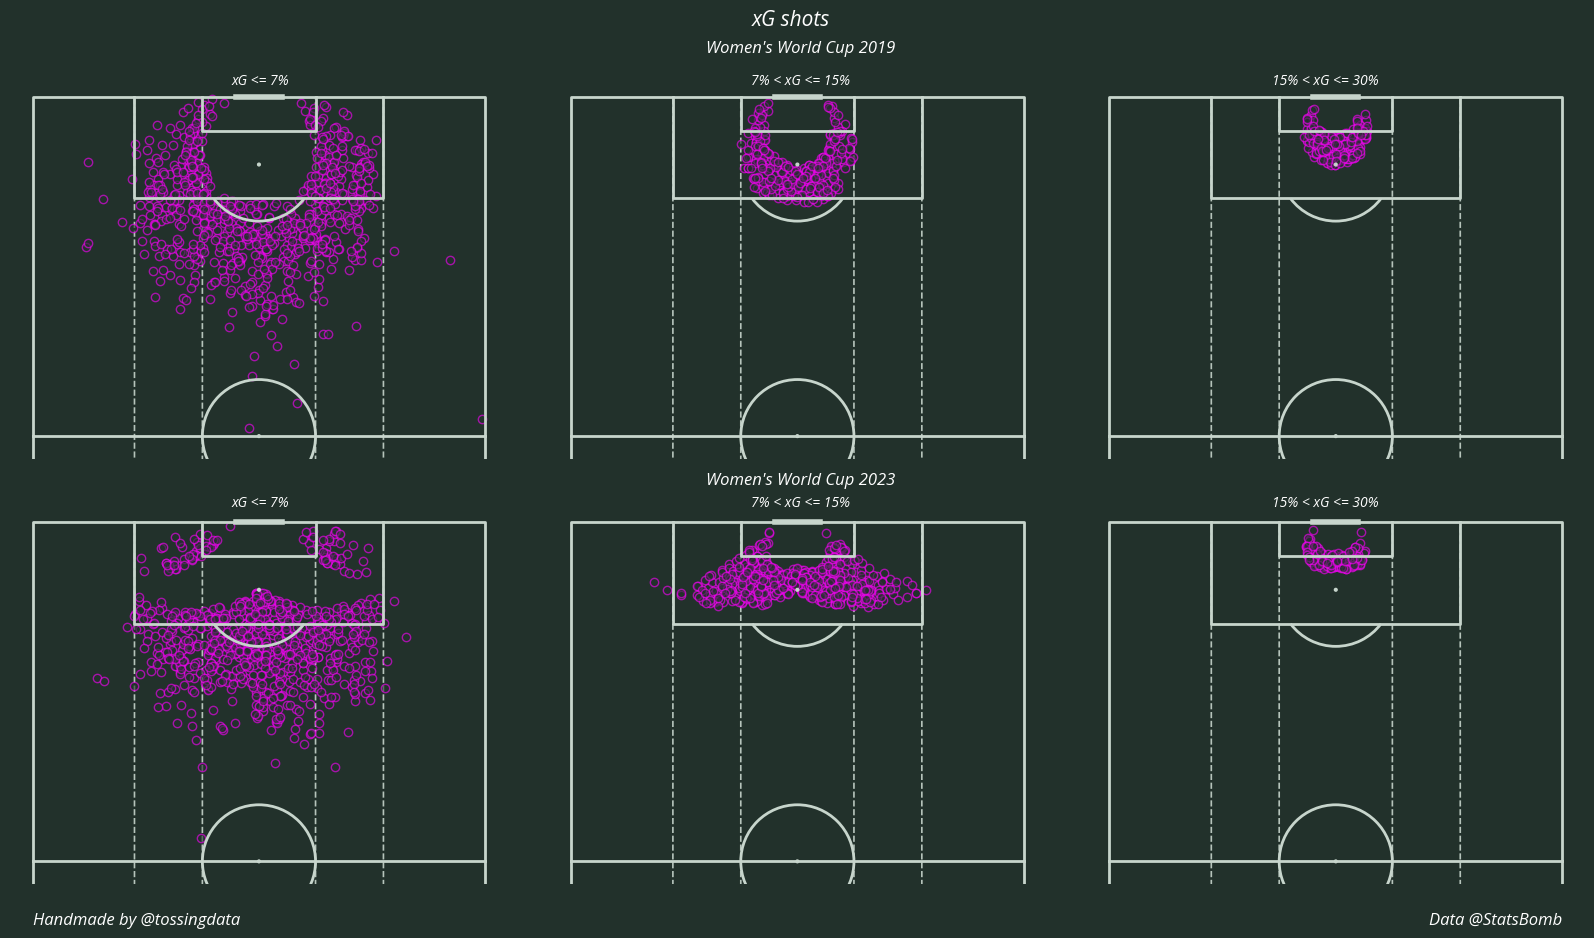

In [21]:
#applaying mask for Women's World Cup 2019 df
xg_prob_7_wc_women_2019 = shots_wc_women_2019.loc[(shots_wc_women_2019['xG_prob'] <= 7)] #xG less or equal 7%
xg_prob_15_wc_women_2019 = shots_wc_women_2019.loc[(shots_wc_women_2019['xG_prob'] <= 15) & (shots_wc_women_2019['xG_prob'] > 7)] #xG less or equal 15%, bigger than 7%
xg_prob_30_wc_women_2019 = shots_wc_women_2019.loc[(shots_wc_women_2019['xG_prob'] <= 30) & (shots_wc_women_2019['xG_prob'] > 15)] #xG less or equal 30%, bigger than 15%

#applaying mask for Women's World Cup 2023 df
xg_prob_7_wc_women_2023 = shots_wc_women_2023.loc[(shots_wc_women_2023['xG_prob'] <= 7)] #xG less or equal 7%
xg_prob_15_wc_women_2023 = shots_wc_women_2023.loc[(shots_wc_women_2023['xG_prob'] <= 15) & (shots_wc_women_2023['xG_prob'] > 7)] #xG less or equal 15%, bigger than 7%
xg_prob_30_wc_women_2023 = shots_wc_women_2023.loc[(shots_wc_women_2023['xG_prob'] <= 30) & (shots_wc_women_2023['xG_prob'] > 15)] #xG less or equal 30%, bigger than 15%

xg_wc_all = [xg_prob_7_wc_women_2019,
             xg_prob_15_wc_women_2019,
             xg_prob_30_wc_women_2019,
             xg_prob_7_wc_women_2023,
             xg_prob_15_wc_women_2023,
             xg_prob_30_wc_women_2023
             ]

#plot pitch
pitch = VerticalPitch(pitch_color='#22312b', line_color='#c7d5cc', half = True, pitch_type='statsbomb', line_zorder = 2, axis=False, tick=False)
fig, axs = pitch.grid(ncols=3, nrows=2, grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#params
fig.set_facecolor('#22312b')
edgecolor='#22312b'
color='#22312b'
alpha=0.6
c='#ffffff'
edgecolors='#FF00FF'

#colorbar ticks params
params = {'xtick.color' : '#ffffff',
          'ytick.color' : '#ffffff'}

plt.rcParams.update(params)

#looping through the grid axes and plot each footbal fields (grid with 6 fields)
for idx, ax in enumerate(axs['pitch'].flatten()):
  #only plot appropriate pitch with respective data from our list of df
    for i, ele in enumerate(xg_wc_all):
      if idx == i:
        #plot sccatter
        pcm = pitch.scatter(ele.X, ele.Y, c=color, ax=ax, alpha=alpha, edgecolors=edgecolors)

    #plot halfspaces lines
    pitch.lines(0, 18, 120, 18, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    pitch.lines(18, 30, 120, 30, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    pitch.lines(18, 50, 120, 50, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    pitch.lines(0, 62, 120, 62, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)

#title
axs['title'].text(x=0.47, y=0.9, s="xG shots", fontsize=15, c=c)
axs['title'].text(x=0.44, y=0.4, s="Women's World Cup 2019", fontsize=12, c=c)
axs['title'].text(x=0.13, y=-0.2, s='xG <= 7%', fontsize=10, c=c)
axs['title'].text(x=0.47, y=-0.2, s='7% < xG <= 15%', fontsize=10, c=c)
axs['title'].text(x=0.81, y=-0.2, s='15% < xG <= 30%', fontsize=10, c=c)
axs['title'].text(x=0.44, y=-7.6, s="Women's World Cup 2023", fontsize=12, c=c)
axs['title'].text(x=0.13, y=-8., s='xG <= 7%', fontsize=10, c=c)
axs['title'].text(x=0.47, y=-8., s='7% < xG <= 15%', fontsize=10, c=c)
axs['title'].text(x=0.81, y=-8., s='15% < xG <= 30%', fontsize=10, c=c)

#endnote
axs['endnote'].text(0, 0., 'Handmade by @tossingdata',
                    fontsize=12,
                    va='center',
                    ha='left',
                    c=c
                    )

axs['endnote'].text(1.0, 0., 'Data @StatsBomb',
                    fontsize=12,
                    va='center',
                    ha='right',
                    c=c
                    )
#plot display
plt.show()
# plt.savefig("xG_world_cup.png", bbox_inches='tight')

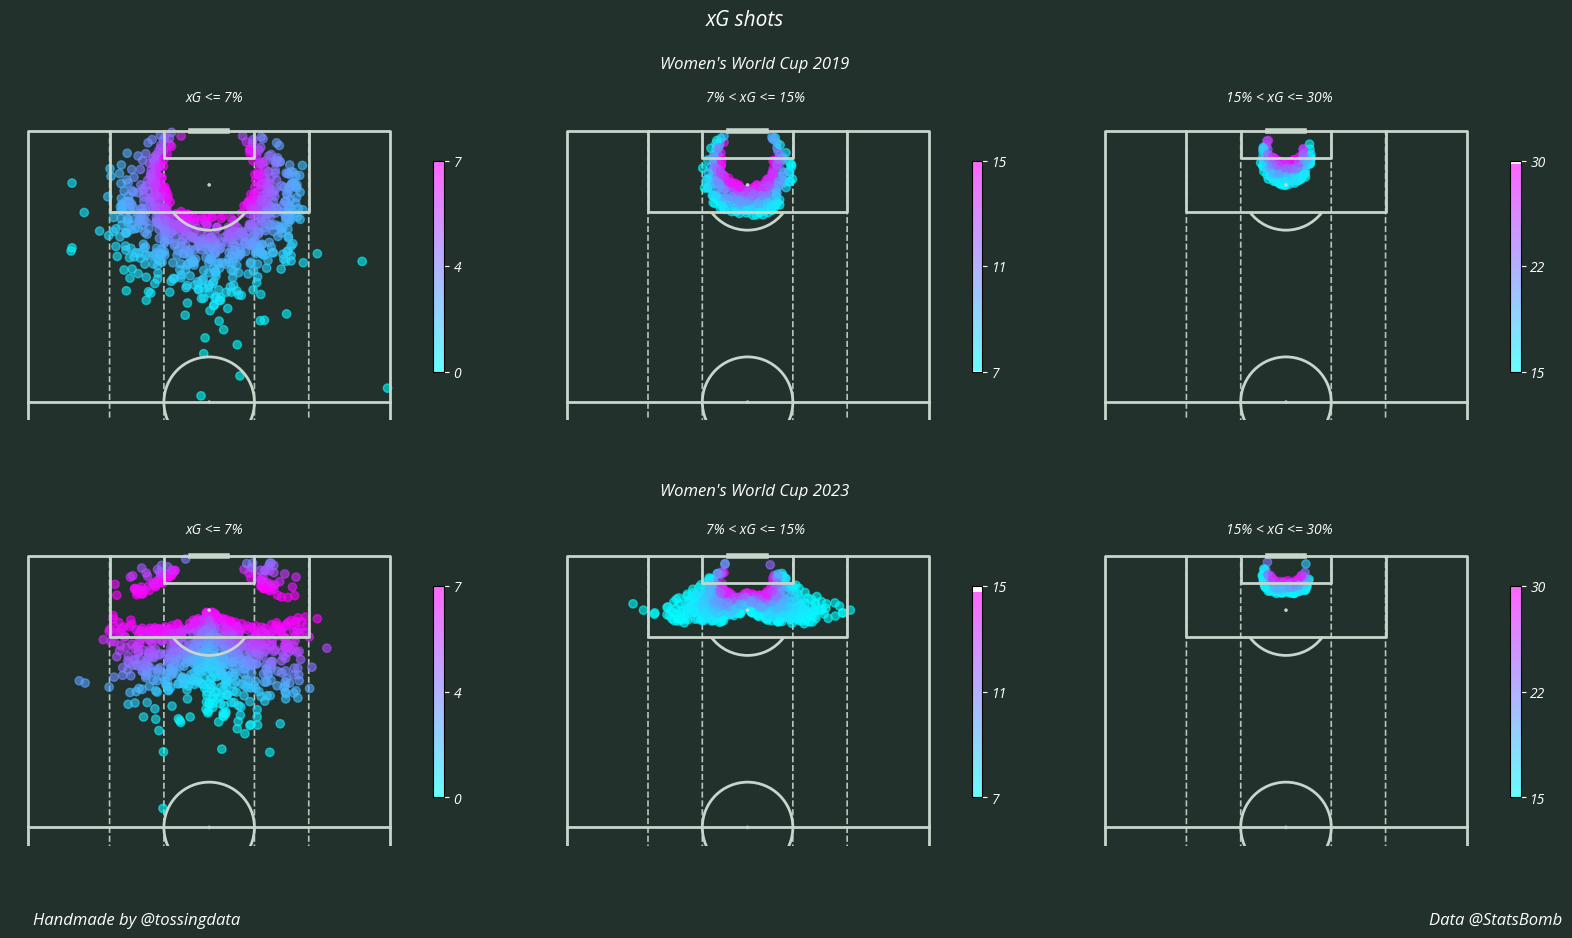

In [22]:
#plot pitch for model maps
pitch = VerticalPitch(pitch_color='#22312b', line_color='#c7d5cc', half = True, pitch_type='statsbomb', line_zorder = 2, axis=False, tick=False)
fig, axs = pitch.grid(ncols=3, nrows=2, grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#params
fig.set_facecolor('#22312b')
edgecolor='#22312b'
color='#22312b'
alpha=0.6
c='#ffffff'
edgecolors='#FF00FF'
cmap = 'cool'

#colorbar ticks params
params = {'xtick.color' : '#ffffff',
          'ytick.color' : '#ffffff'}

plt.rcParams.update(params)

#looping through the grid axes and plot each footbal fields (grid with 6 fields)
for idx, ax in enumerate(axs['pitch'].flatten()):
  #only plot appropriate pitch with respective data from our list of df
    for i, ele in enumerate(xg_wc_all):
      if idx == i:
        #plot scatter
        pcm = pitch.scatter(ele.X, ele.Y, c=ele.xG_prob, cmap=cmap, ax=ax, alpha=alpha)
        #adding colorbar
        cbar = plt.colorbar(pcm, ax=ax, shrink=0.55)
        #define range for colorbar ticks
        ticks = np.linspace(round(ele.xG_prob.min()), round(ele.xG_prob.max()), num=3)
        cbar.set_ticks(ticks)
        #formatting ticks labels
        cbar.ax.set_yticklabels(["{:.0f}".format(i) for i in ticks])

    #plot halfspaces lines
    pitch.lines(0, 18, 120, 18, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    pitch.lines(18, 30, 120, 30, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    pitch.lines(18, 50, 120, 50, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    pitch.lines(0, 62, 120, 62, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)

#title
axs['title'].text(x=0.44, y=0.9, s="xG shots", fontsize=15, c=c)
axs['title'].text(x=0.41, y=0.1, s="Women's World Cup 2019", fontsize=12, c=c)
axs['title'].text(x=0.10, y=-0.5, s='xG <= 7%', fontsize=10, c=c)
axs['title'].text(x=0.44, y=-0.5, s='7% < xG <= 15%', fontsize=10, c=c)
axs['title'].text(x=0.78, y=-0.5, s='15% < xG <= 30%', fontsize=10, c=c)
axs['title'].text(x=0.41, y=-7.8, s="Women's World Cup 2023", fontsize=12, c=c)
axs['title'].text(x=0.10, y=-8.5, s='xG <= 7%', fontsize=10, c=c)
axs['title'].text(x=0.44, y=-8.5, s='7% < xG <= 15%', fontsize=10, c=c)
axs['title'].text(x=0.78, y=-8.5, s='15% < xG <= 30%', fontsize=10, c=c)

#endnote
axs['endnote'].text(0, 0., 'Handmade by @tossingdata',
                    fontsize=12,
                    va='center',
                    ha='left',
                    c=c
                    )

axs['endnote'].text(1.0, 0., 'Data @StatsBomb',
                    fontsize=12,
                    va='center',
                    ha='right',
                    c=c
                    )
#plot display
plt.show()
# plt.savefig("xG_world_cup_cmap.png", bbox_inches='tight')

###Women's Super League

In [18]:
##applaying transfor function and saving the data to new variables
season_2018 = data_model_extraction(season_2018)
season_2019 = data_model_extraction(season_2019)
season_2020 = data_model_extraction(season_2021)

#applaying xG model function and saving the data to new variables
shots_season_2018 = xG_model(season_2018)
shots_season_2019 = xG_model(season_2019)
shots_season_2020 = xG_model(season_2020)

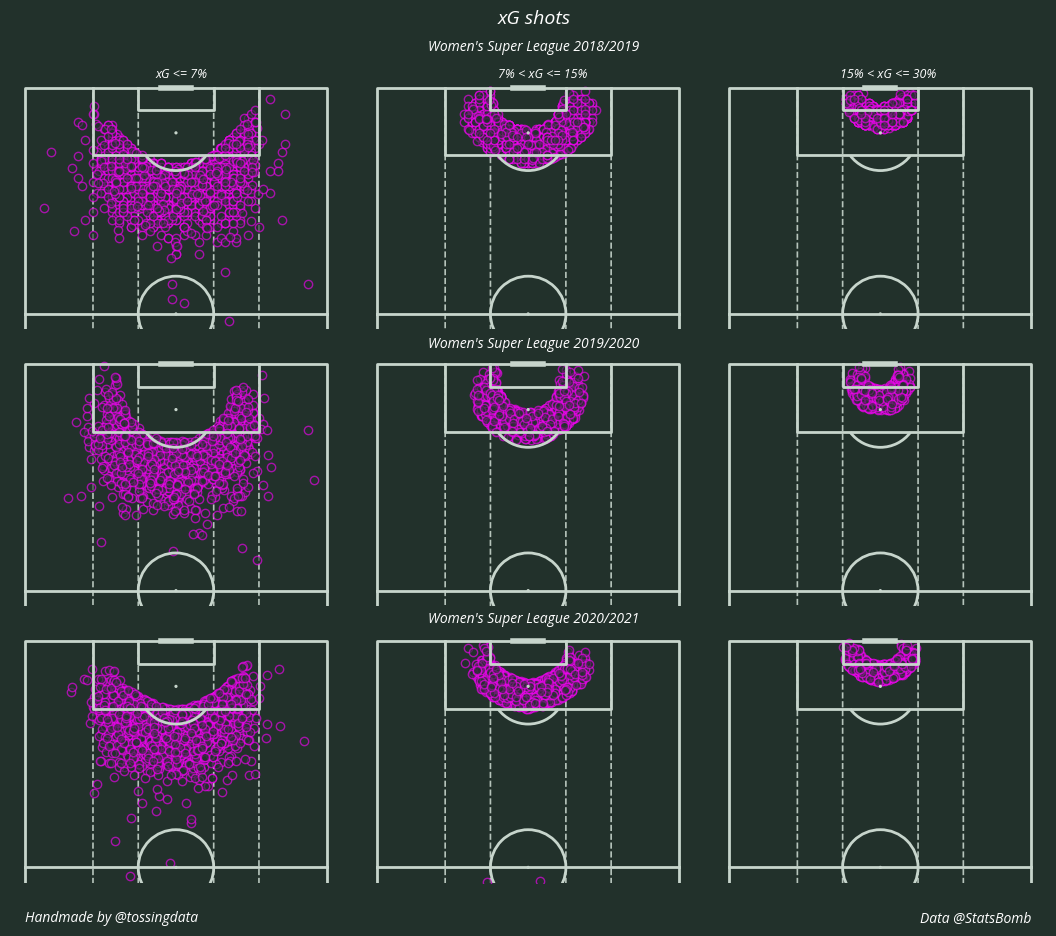

In [25]:
#applaying mask for WSL season 2018 df
xg_prob_7_season_2018 = shots_season_2018.loc[(shots_season_2018['xG_prob'] <= 7)] #xG less or equal 7%
xg_prob_15_season_2018 = shots_season_2018.loc[(shots_season_2018['xG_prob'] <= 15) & (shots_season_2018['xG_prob'] > 7)] #xG less or equal 15%, bigger than 7%
xg_prob_30_season_2018 = shots_season_2018.loc[(shots_season_2018['xG_prob'] <= 30) & (shots_season_2018['xG_prob'] > 15)] #xG less or equal 30%, bigger than 15%

#applaying mask for WSL 2019 df
xg_prob_7_season_2019 = shots_season_2019.loc[(shots_season_2019['xG_prob'] <= 7)] #xG less or equal 7%
xg_prob_15_season_2019 = shots_season_2019.loc[(shots_season_2019['xG_prob'] <= 15) & (shots_season_2019['xG_prob'] > 7)] #xG less or equal 15%, bigger than 7%
xg_prob_30_season_2019 = shots_season_2019.loc[(shots_season_2019['xG_prob'] <= 30) & (shots_season_2019['xG_prob'] > 15)] #xG less or equal 30%, bigger than 15%

#applaying mask for WSL 2020 df
xg_prob_7_season_2020 = shots_season_2020.loc[(shots_season_2020['xG_prob'] <= 7)] #xG less or equal 7%
xg_prob_15_season_2020 = shots_season_2020.loc[(shots_season_2020['xG_prob'] <= 15) & (shots_season_2020['xG_prob'] > 7)] #xG less or equal 15%, bigger than 7%
xg_prob_30_season_2020 = shots_season_2020.loc[(shots_season_2020['xG_prob'] <= 30) & (shots_season_2020['xG_prob'] > 15)] #xG less or equal 30%, bigger than 15%

xg_season_all = [xg_prob_7_season_2018,
                 xg_prob_15_season_2018,
                 xg_prob_30_season_2018,
                 xg_prob_7_season_2019,
                 xg_prob_15_season_2019,
                 xg_prob_30_season_2019,
                 xg_prob_7_season_2020,
                 xg_prob_15_season_2020,
                 xg_prob_30_season_2020]

#plot pitch
pitch = VerticalPitch(pitch_color='#22312b', line_color='#c7d5cc', half = True, pitch_type='statsbomb', line_zorder = 2, axis=False, tick=False)
fig, axs = pitch.grid(ncols=3, nrows=3, grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0
                      )

#params
fig.set_facecolor('#22312b')
edgecolor='#22312b'
color='#22312b'
alpha=0.6
c='#ffffff'
edgecolors='#FF00FF'

#colorbar ticks params
params = {'xtick.color' : '#ffffff',
          'ytick.color' : '#ffffff'}

plt.rcParams.update(params)

#looping through the grid axes and plot each footbal fields (grid with 6 fields)
for idx, ax in enumerate(axs['pitch'].flatten()):
  #only plot appropriate pitch with respective data from our list of df
    for i, ele in enumerate(xg_season_all):
      if idx == i:
        #plot scatter
        pcm = pitch.scatter(ele.X, ele.Y, c=color, ax=ax, alpha=alpha, edgecolors=edgecolors)

    #plot halfspaces lines
    pitch.lines(0, 18, 120, 18, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    pitch.lines(18, 30, 120, 30, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    pitch.lines(18, 50, 120, 50, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    pitch.lines(0, 62, 120, 62, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)

#title
axs['title'].text(x=0.47, y=0.9, s="xG shots", fontsize=14, c=c)
axs['title'].text(x=0.40, y=0.4, s="Women's Super League 2018/2019", fontsize=10, c=c)
axs['title'].text(x=0.40, y=-5.1, s="Women's Super League 2019/2020", fontsize=10, c=c)
axs['title'].text(x=0.40, y=-10.2, s="Women's Super League 2020/2021", fontsize=10, c=c)
axs['title'].text(x=0.13, y=-0.1, s='xG <= 7%', fontsize=9, c=c)
axs['title'].text(x=0.47, y=-0.1, s='7% < xG <= 15%', fontsize=9, c=c)
axs['title'].text(x=0.81, y=-0.1, s='15% < xG <= 30%', fontsize=9, c=c)

#endnote
axs['endnote'].text(0, 0., 'Handmade by @tossingdata',
                    fontsize=10,
                    va='center',
                    ha='left',
                    c=c
                    )

axs['endnote'].text(1.0, 0., 'Data @StatsBomb',
                    fontsize=10,
                    va='center',
                    ha='right',
                    c=c
                    )
#plot display
plt.show()
# plt.savefig("xG_season.png", bbox_inches='tight')

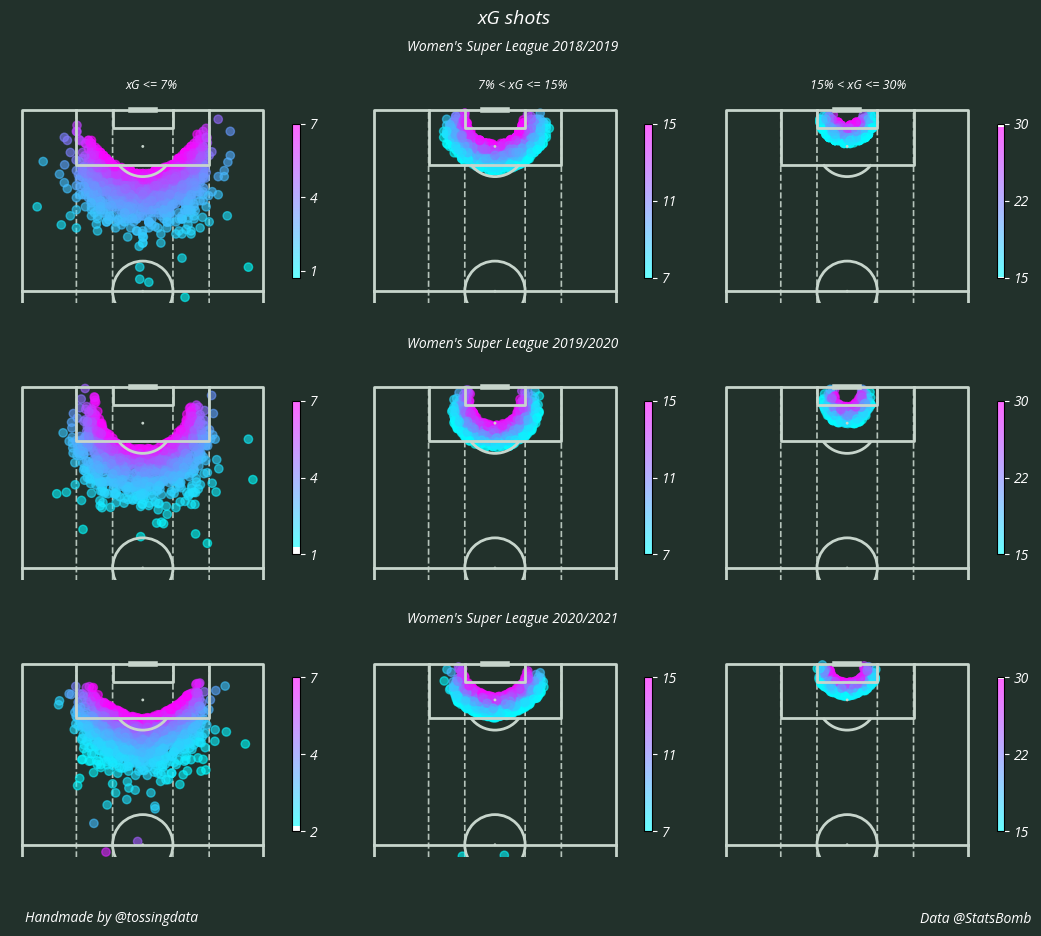

In [26]:
#plot pitch for model maps
pitch = VerticalPitch(pitch_color='#22312b', line_color='#c7d5cc', half = True, pitch_type='statsbomb', line_zorder = 2, axis=False, tick=False)
fig, axs = pitch.grid(ncols=3, nrows=3, grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

#params
fig.set_facecolor('#22312b')
edgecolor='#22312b'
color='#22312b'
alpha=0.6
c='#ffffff'
edgecolors='#FF00FF'
cmap = 'cool'

#colorbar ticks params
params = {'xtick.color' : '#ffffff',
          'ytick.color' : '#ffffff'}

plt.rcParams.update(params)

#looping through the grid axes and plot each footbal fields (grid with 6 fields)
for idx, ax in enumerate(axs['pitch'].flatten()):
  #only plot appropriate pitch with respective data from our list of df
    for i, ele in enumerate(xg_season_all):
      if idx == i:
        #plot scatter
        pcm = pitch.scatter(ele.X, ele.Y, c=ele.xG_prob, cmap=cmap, ax=ax, alpha=alpha)
        #adding colorbar
        cbar = plt.colorbar(pcm, ax=ax, shrink=0.6)
        #define range for colorbar ticks
        ticks = np.linspace(round(ele.xG_prob.min()), round(ele.xG_prob.max()), num=3)
        cbar.set_ticks(ticks)
        #formatting ticks labels
        cbar.ax.set_yticklabels(["{:.0f}".format(i) for i in ticks])

    #plot halfspaces lines
    pitch.lines(0, 18, 120, 18, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    pitch.lines(18, 30, 120, 30, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    pitch.lines(18, 50, 120, 50, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    pitch.lines(0, 62, 120, 62, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)
    # pitch.lines(94, 0, 94, 80, ax=ax, color = '#c7d5cc', ls = "--", alpha= 0.9, lw = 1.2, zorder = 0)

#title
axs['title'].text(x=0.45, y=0.9, s="xG shots", fontsize=14, c=c)
axs['title'].text(x=0.38, y=0.4, s="Women's Super League 2018/2019", fontsize=10, c=c)
axs['title'].text(x=0.38, y=-5.1, s="Women's Super League 2019/2020", fontsize=10, c=c)
axs['title'].text(x=0.38, y=-10.2, s="Women's Super League 2020/2021", fontsize=10, c=c)
axs['title'].text(x=0.10, y=-0.3, s='xG <= 7%', fontsize=9, c=c)
axs['title'].text(x=0.45, y=-0.3, s='7% < xG <= 15%', fontsize=9, c=c)
axs['title'].text(x=0.78, y=-0.3, s='15% < xG <= 30%', fontsize=9, c=c)

#endnote
axs['endnote'].text(0, 0., 'Handmade by @tossingdata',
                    fontsize=10,
                    va='center',
                    ha='left',
                    c=c
                    )

axs['endnote'].text(1.0, 0., 'Data @StatsBomb',
                    fontsize=10,
                    va='center',
                    ha='right',
                    c=c
                    )
#plot display
plt.show()
# plt.savefig("xG_season_cmap.png", bbox_inches='tight')